# Explore an HCA data set in Scanpy (November 2018 version)
This notebook shows a few quick steps to start exploring an example HCA data sets using [scanpy](https://github.com/theislab/scanpy) ([citation](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0)).

In [1]:
%matplotlib inline

import loompy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='Greys')
sc.logging.print_versions()

# Let's write results to a temporary file
import tempfile
results_file = tempfile.NamedTemporaryFile(delete=False, suffix='.h5ad').name
print("The results file is here: " + results_file)

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.4.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.11.0rc1 python-igraph==0.7.1 louvain==0.6.1
The results file is here: /var/folders/qn/bgn0p0v96w1g6fxsdmvd3qrm0000gq/T/tmp5d_y1wrj.h5ad


## Read the expression matrix file downloaded from the HCA
The file shown here is from the study [Single-Cell Analysis of Human Pancreas Reveals Transcriptional Signatures of Aging and Somatic Mutation Patterns by Enge, et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6047899/), available in this repository at `./pancreas.loom`

In [2]:
adata = sc.read_loom('pancreas.loom', sparse=True, cleanup=False, 
                     X_name='spliced', obs_names='CellID', var_names='Gene')

## Query for genes of interest

HCA uses Gencode nomenclature as gene identifiers. A list of these identifiers and their corresponding gene symbols is included in this repository as `./ENSG_to_name.csv`

Here we show a quick way to query for the ENSG IDs of your genes of interest.

In [3]:
gene_names = pd.read_csv('ENSG_to_name.csv', index_col = 0)
named_list = adata.var.join(gene_names)

In [4]:
named_list.query('name == ["GCG"]') ## replace GCG with gene of interest 

,name
ENSG00000115263.14,GCG


## Filter and normalize
Here we go through several steps to clean up the data:
- Filter out genes that are present in few cells, cells that contain few genes
- Transform the sum of (remaining) gene expression counts in each cell to equal the same number (1e4)
- Keep 500 highest expressed genes from each cell (this threshold used in initial publication)

In [5]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)

adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
dat = sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)

# here we'll make "top", which is the union of the top 500 expressed genes from each cell
top = []
for i in range(dat.shape[0]):
    indices = np.asarray(np.argsort(dat.X[i,:].todense())[0,:]).flatten()[::-1][0:500]
    top = np.union1d(top, indices)
    
# update adata to include only the list "top"
adata = adata[:, top.astype('int')]

filtered out 23283 genes that are detectedin less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Perform dimensionality reduction and clustering
- Compute the principal components
- Generate the neighborhood graph
- Determine clusters using Louvain method
- Perform dimensionality reduction with UMAP
- Perform dimensionality reduction with tSNE

In [6]:
sc.pp.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.louvain(adata, resolution=0.15)
sc.tl.tsne(adata)
sc.tl.umap(adata)
adata.write(results_file)

computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


... storing 'ACCUMULATION_LEVEL' as categorical
... storing 'PAIR_ORIENTATION' as categorical
... storing 'READS_USED' as categorical


### Determine weighted expression of select genes
This will be used in a few figures below

In [7]:
genes = ['ENSG00000254647.6', 'ENSG00000115263.14', 'ENSG00000157005.3', 'ENSG00000204983.13', #INS #GCG #SST #PRSS1
         'ENSG00000007062.11','ENSG00000154096.13', 'ENSG00000108849.7'] #PRSS1 #PROM1 #THY1 #PPY
colors = np.asarray([[226,43,34], [67,114,175], [48,178,78], 
                     [139,47,175], [244,152,46], [249,246,49], [119,73,27]])
weights = adata[:,genes].X.todense()
weights = weights / (weights.sum(axis=1) + 0.0001)
c = np.dot(weights, colors)

## Embed cells using tSNE

The example used in this notebook is a study of pancreas cells. Below, clusters are plotted alongside three genes that are known to mark different pancreas cell types.
HCA uses Gencode nomenclature as gene identifiers. See the section above titled `Query for genes of interest`.

Shown below:
- INS: ENSG00000254647.6 
- GCG: ENSG00000115263.14 
- PRSS1: ENSG00000204983.13

Not shown below, but feel free to try on your own:
- SST: ENSG00000157005.3 
- PROM1: ENSG00000007062.11
- THY1: ENSG00000154096.13    
- PPY: ENSG00000108849.7

### The quick way to plot in tSNE space

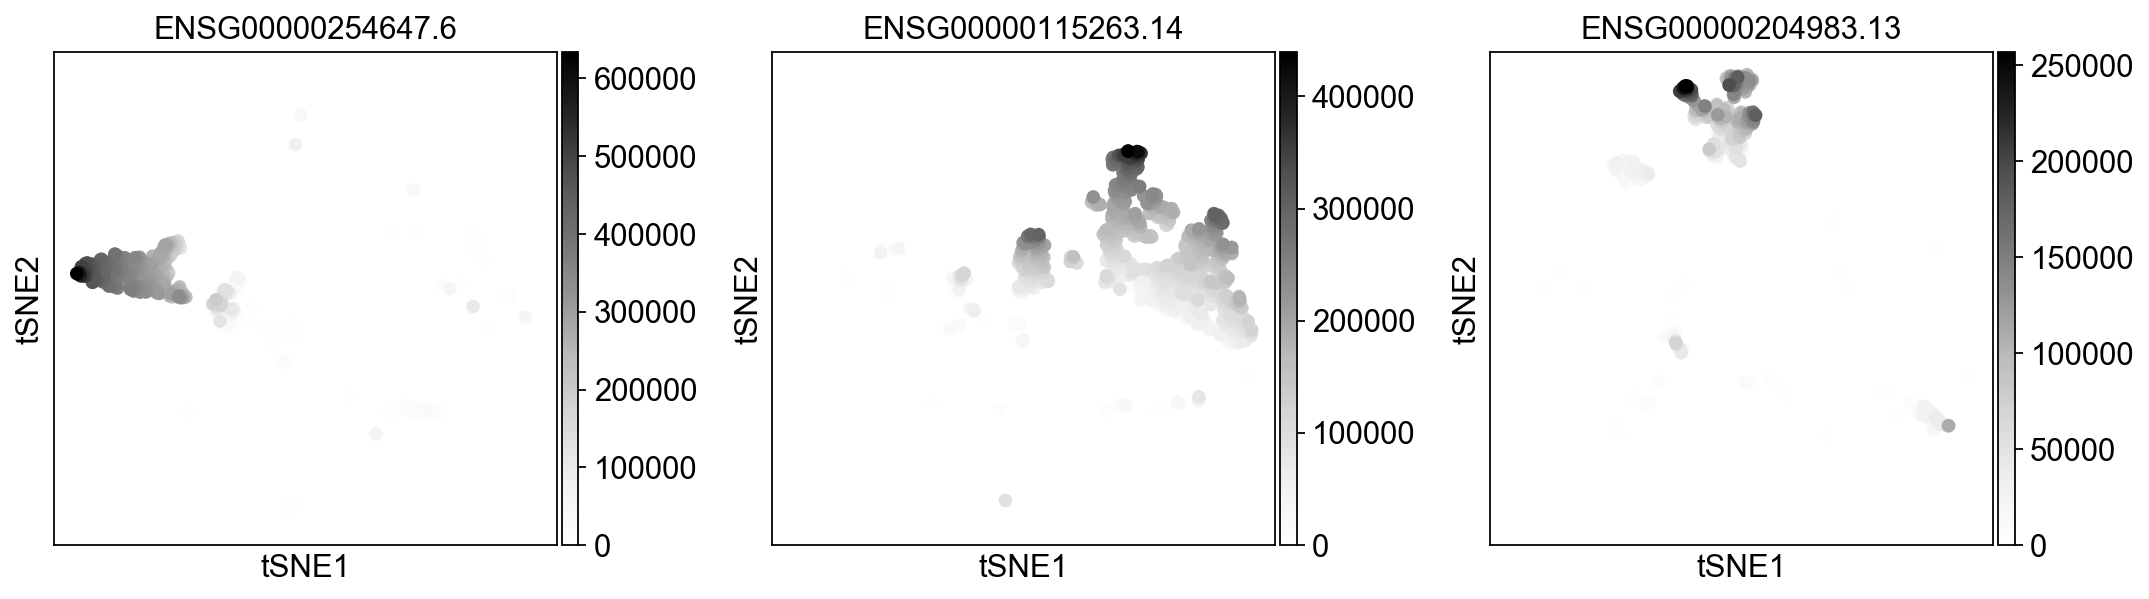

In [8]:
sc.pl.tsne(adata, color=['ENSG00000254647.6', 'ENSG00000115263.14', 'ENSG00000204983.13'], 
           wspace=0.3, size=150, linewidths=0.3, edgecolors='black');

### A slightly prettier custom plot

/Users/charles/codes/data-consumer-vignettes/vp/lib/python3.6/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


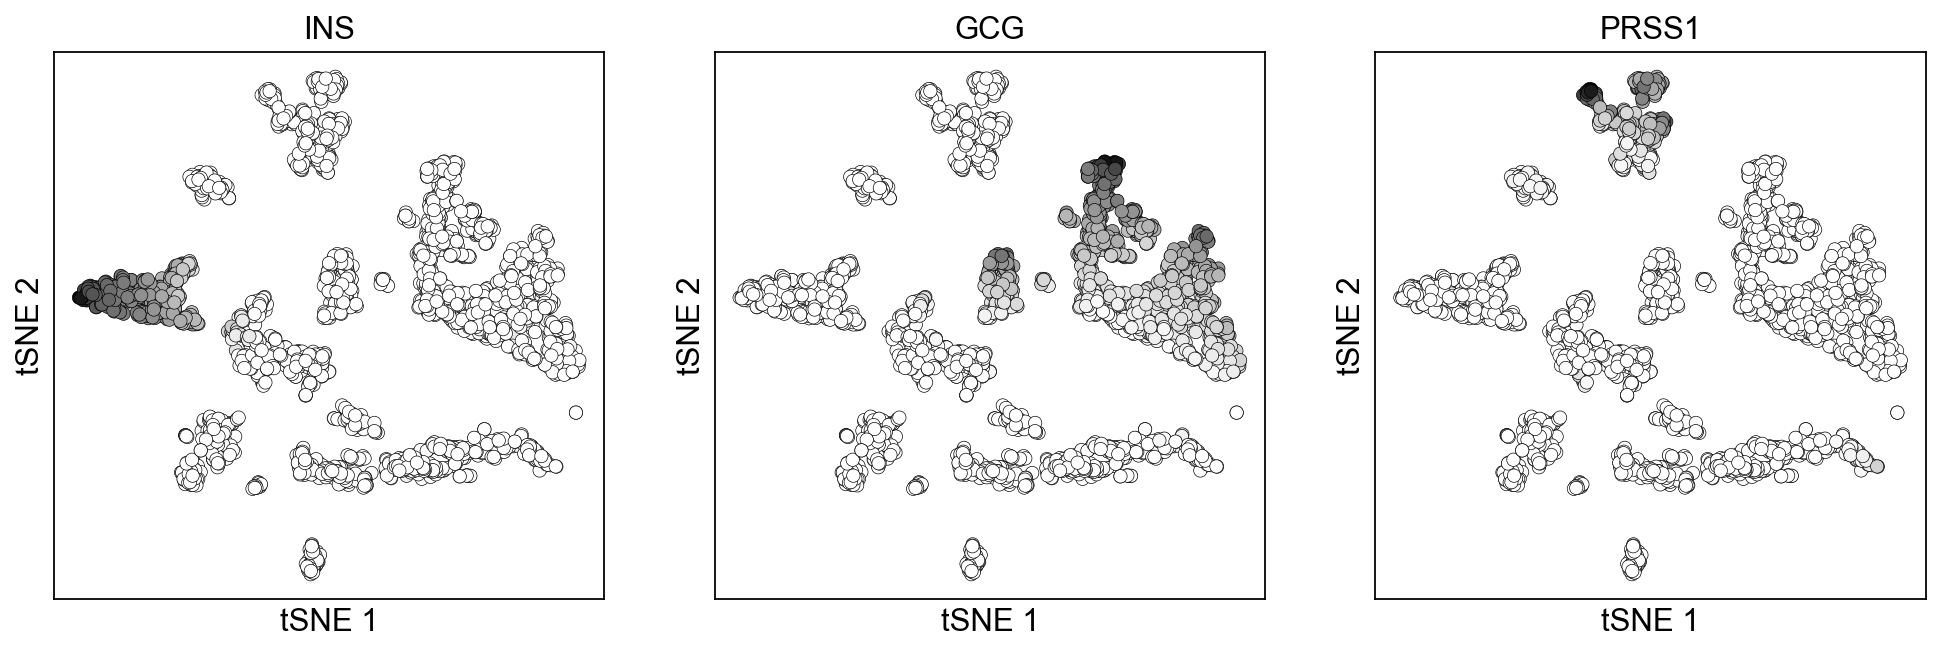

In [9]:
def clean_plot():
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')

plt.figure(figsize=[15,4.5])
ids = ['ENSG00000254647.6', 'ENSG00000115263.14', 'ENSG00000204983.13']
genes = ['INS', 'GCG', 'PRSS1']
plots = [131, 132, 133]
for i, g, p in zip(ids, genes, plots):
    plt.subplot(p);
    plt.scatter(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], c=adata[:,i].X,
                linewidths=0.3, edgecolors='black');
    plt.title(g)
    clean_plot()

### Cells colored by weighted expression of select genes

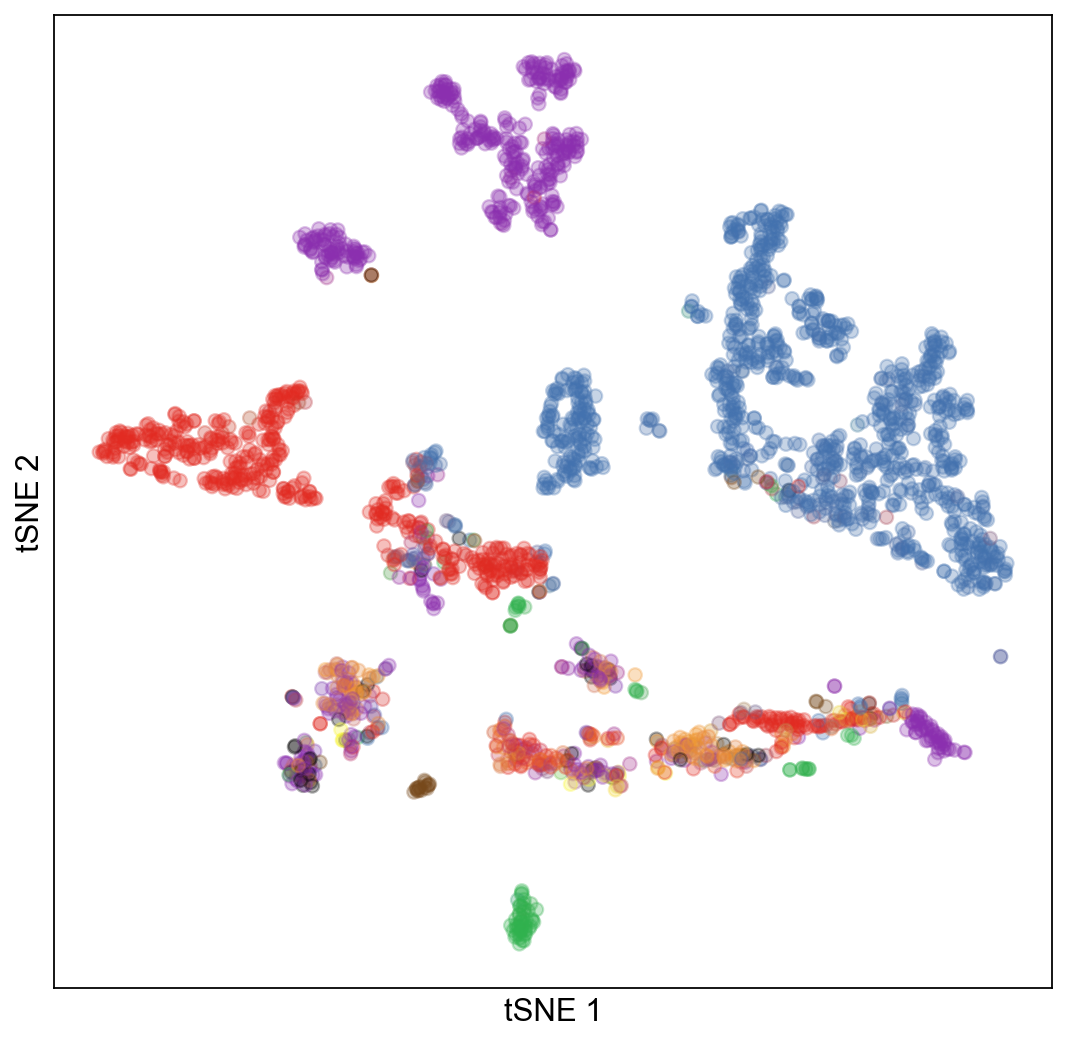

In [10]:
plt.figure(figsize=[8, 8])
plt.scatter(adata.obsm['X_tsne'][:,0], adata.obsm['X_tsne'][:,1], c=c/255, alpha=0.3);
clean_plot()

## Embed cells using UMAP

The same clusters and markers can be viewed using alternative embeddings:

### Cells colored by louvain clustering

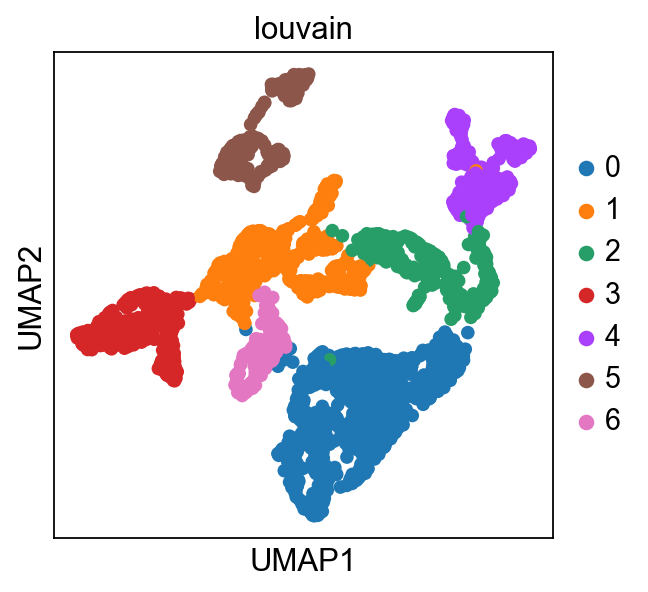

In [11]:
sc.pl.umap(adata, color='louvain', wspace=0.3, size=150, linewidths=0.3, edgecolors='black');

### Cells colored by weighted expression of select genes

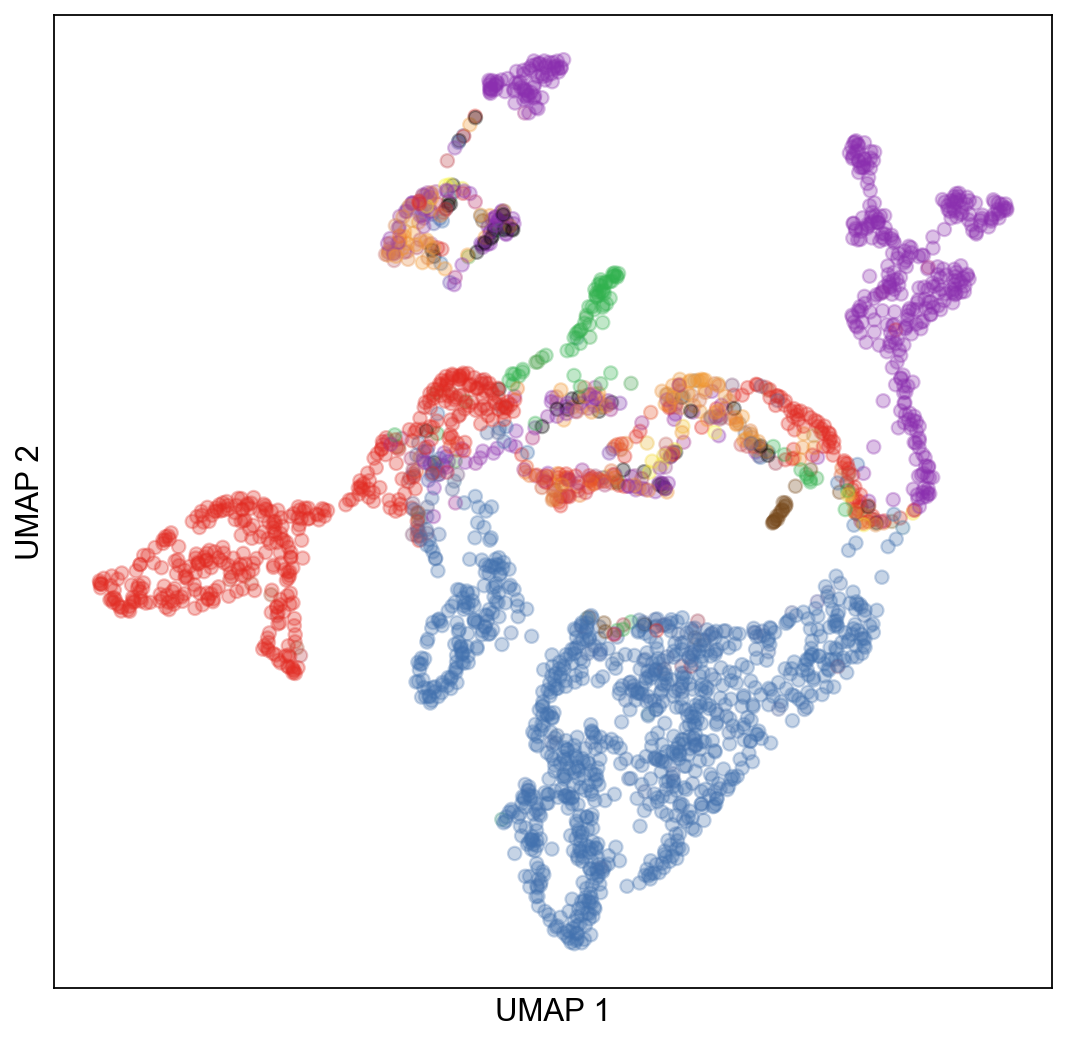

In [12]:
plt.figure(figsize=[8, 8])
plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=c/255, alpha=0.3);
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2');

## Where to go from here
There are many more ways to explore the data you've downloaded from the HCA -- see the scanpy tutorials for ideas https://scanpy.readthedocs.io/en/latest/examples.html#